# **Extra 3 - Style Transfer**

<img src="style_transfer_images/finale.png" width="400">

En aquest Notebook hem volgut provar de fer *Style Transfer* mitjançant directament la llibreria *Pytorch*. Donat que l'Style Transfer és quelcom totalment nou per nosaltres -i tampoc era ben bé l'objecte d'aquesta assignatura- hem basat el nostre programa en l'exemple oficial de la pàgina de Pytorch ( https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) i aquest altre exemple de TDS (https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa ), preocupant-nos més d'entendre el funcionament que no pas d'afegir millores o modificacions.

### **0. Preliminars**

Primerament, necessitarem dues imatges per transferir l'estil d'una cap a l'altra, i les haurem de guardar en el mateix directori on estiguem executant aquest *Notebook*. Nosaltres hem elegit aquestes dues imatges, que estàn disponibles al repositori, sota la carpeta 'style_transfer_images':

<img src="style_transfer_images/style.jpg" width="400">

<img src="style_transfer_images/cf_gauss.jpg" width="400">

Una vegada aconseguides les imatges d'exemple, carreguem les llibreries que necessitarem per l'experiment:

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.utils import save_image

from PIL import Image
from IPython.display import display

I finalment indiquem a ``pytorch`` que volem treballar amb CUDA en cas de tenir una GPU disponible:

In [17]:
device=torch.device( 'cuda' if (torch.cuda.is_available()) else 'cpu')

I, amb això, ja estem a punt per corrompre el retrat del Sr. Gauss.

### **1. Preprocessat d'imatge**

Començarem creant un *image loader*, que consistirà en un mètode que agafarà una imatge localitzada en un path determinat, la escalarà a 512 x 512 píxels (a més dimensió, més detall i més s'apreciarà la transferència d'estil, però més GPU consumirem), la convertirem a tensor i l'enviarem a la CUDA:

In [18]:
def ImageLoader(path):
    
    image = Image.open(path)
    loader=transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

Carreguem ara les dues imatges d'exemple. El retrat de nostre senyor i salvador C.F. Gauss serà la *content image*, és a dir, la imatge amb el contingut que volem transformar. L'altre serà la *style image*, és a dir, la imatge amb les features que volem imitar:

In [19]:
content_image = ImageLoader('cf_gauss.jpg')
style_image = ImageLoader('style.jpg')

Creem també una còpia de la imatge de continguts, que anomenarem *imatge generada*. La idea serà anar distorsionant i transformant aquesta imatge perquè es vagi assemblant cada cop més a la imatge d'estil.

In [37]:
generated_image=content_image.clone().requires_grad_(True)

<br>

### **2. Arquitectura**

Abans de definir l'arquitectura neuronal que farem servir per transferir l'estil, ens convé discutir breument quina és la idea darrere del *Transfer Learning*.

El *Transfer Learning* treu profit del fet de que les capes d'una xarxa convolucional, després d'entrenar-se, s'acaben especialitzant en reconèixer certs tipus de features concretes que són més complexes a mesura que es va avançant a capes més profundes.

La idea és agafar una xarxa convolucional pre-entrenada (per exemple, la VGG19) i quedar-nos només amb una selecció de capes determinades. Aquestes capes s'entrenen amb una funció de loss especial que definirem més endavant, comparant la diferència entre la imatge original i la imatge d'estil.

In [21]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # Ens quedem amb les capes convolucionals núm. 1,2,3,4 i 5, que
        # en la implementació de Pytorch de la VGG19 es pot comprovar (si  
        # miréssim el funcionament intern) que corresponen a les següents features:
        self.req_features = ['0', '5', '10', '19', '28']
        
        # Guardem les primeres 29 features del model, malgrat que només considerarem
        # les activacions de les features que hem definit a l'array anterior:
        self.model = models.vgg19(pretrained = True).features[:29]
        
    def forward(self,x):
        
        # La idea de la propagació cap d'aquesta xarxa aplicada al transfer learning
        # serà una mica diferent a la habitual.
        # En comptes d'agafar l'input x i propagar-lo per tota la xarxa, únicament
        # el propagarem per les features (a.k.a. capes) definides a l'array req_features,
        # i ens guardarem l'output d'aquestes capes per calcular el loss.        
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            
            if str(layer_num) in self.req_features:
                features.append(x)
                
        return features

<br>

### **3. Loss**

Hem de crear primerament dues funcions de loss. La primera, consistirà en la mitjana de la diferència al quadrat entre les features de la imatge generada i la imatge original:

In [22]:
def ContentLoss(generated_features, content_features):
    
    content_l = torch.mean((generated_features - content_features)**2)
    
    return content_l

La segona funció de loss és bastant semblant, però calcula la diferència al quadrat entre el producte matricial de la imatge generada amb ella mateixa, i la imatge d'estil amb ella mateixa:

In [23]:
def StyleLoss(generated, style):
    batch_size, channel, height, width = generated.shape
    G=torch.mm(generated.view(channel,height*width),generated.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
    style_l=torch.mean((G-A)**2)
    
    return style_l

Finalment, crearem una funció de Loss general que sumarà de manera ponderada l'error de les dues funcions anteriors (d'acord amb dos hiperparàmetres alpha i beta que podrem ajustar):

In [24]:
def Loss(generated_features, content_features, style_features):
    content_loss = 0
    style_loss = content_loss
    
    for gen, cont, style in zip(generated_features, content_features, style_features):
        
        content_loss += ContentLoss(gen, cont)
        style_loss += StyleLoss(gen, style)
        
        
    total_loss = alpha * content_loss + beta*style_loss
    return total_loss

Aquest ``total_loss`` ponderat que retorna la funció ens servirà per entrenar la xarxa.

### **4. (*Re?*)entrenament del model**

Anem a entrenar (o re-entrenar, segons com es miri) la nostra VGG per tal de produïr la imatge mixta:

In [38]:
# Creem la VGG i la carreguem a la CUDA
model = VGG().to(device).eval() 

# Definim hiperparàmetres - depenent de l'estil i la imatge, caldrà jugar amb aquests valors
epoques = 3000
learn_rate = 0.05
alpha = 12
beta = 128
# Altres combinacions interessants:
# alpha = 8, beta = 70, epoques = 3000+
# alpha = 32, beta = 64, epoques = 3000+

# Creem l'optimitzador:
optimizer = optim.Adam([generated_image], lr=lr)


# Iterem els episodis d'entrenament:
for episodi in range(epoques):
    
    # Extraiem les *features* de les tres imatges per calcular-ne el *Loss*:
    gen_features=model(generated_image)
    content_features=model(content_image)
    style_features=model(style_image)
    total_loss = Loss(gen_features, content_features, style_features)
    
    # Passem el loss calculat per l'optimitzador, i propaguem l'error cap enrerre per ajustar els pesos.
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Mostrem un indicador del progrés:
    if (episodi % 100 == 0):
        print("Epoch", episodi)
    
# Un cop hem acabat, guardem la imatge definitiva. És possible que haguem de fer varies proves
# i ajustar alpha, beta i nombre d'èpoques per tal d'aconseguir una imatge que sigui interessant.
save_image(generated_image,"imatge_generada.png")     

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900


Finalment, vegem com ha quedat la imatge transformada:

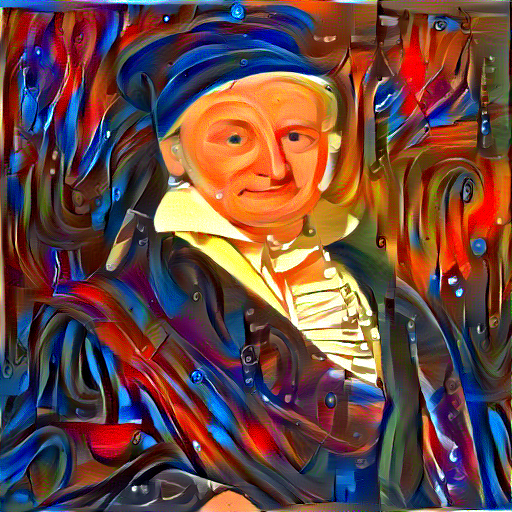

In [40]:
path="imatge_generada.png"
display(Image.open(path))